In [ ]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import pickle

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../week09')))
import track_points_helper

# Adjust the path to your Python version and where the library has been installed
sys.path.append('/zhome/42/8/213460/.local/lib/python3.11/site-packages')
from natsort import natsorted

Loaded UD stack shape: (999, 1013, 988)
Loaded Mock stack shape: (999, 1013, 988)


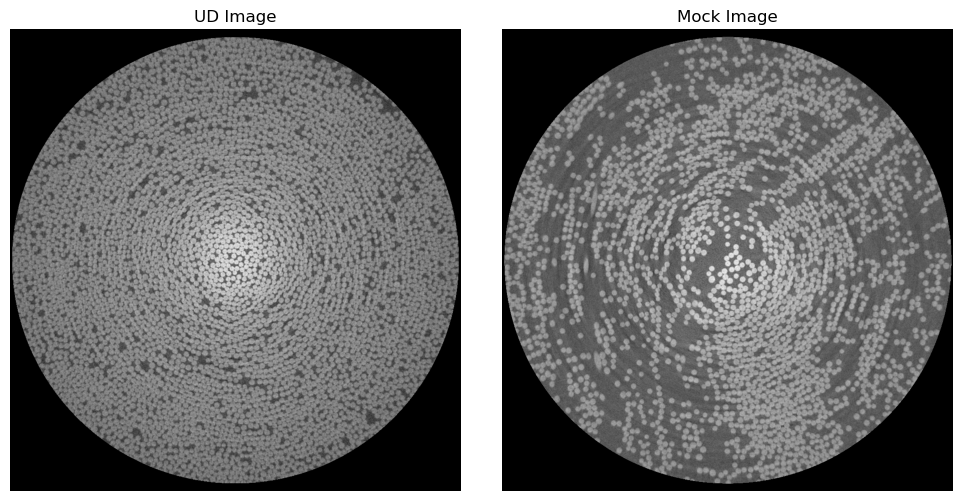

In [ ]:
def load_stack(folder_path):
    file_names = natsorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])
    stack = [tiff.imread(os.path.join(folder_path, f)) for f in file_names]
    return np.stack(stack)

# Paths to extracted slices
path_UD = os.path.join(os.getcwd(), 'data/UD-01_FoV_2_B2_recon_2Dtif')
path_Mock = os.path.join(os.getcwd(), 'data/Mock-01_FoV_2_B2_recon_2Dtif')

# Load stacks
tif_data_UD = load_stack(path_UD)
tif_data_Mock = load_stack(path_Mock)

# Check shapes
print("Loaded UD stack shape:", tif_data_UD.shape)
print("Loaded Mock stack shape:", tif_data_Mock.shape)

# Visualize first slice
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tif_data_UD[0], cmap='gray')
plt.title('UD Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(tif_data_Mock[0], cmap='gray')
plt.title('Mock Image')
plt.axis('off')
plt.tight_layout()
plt.show()